Пока что относительно нормальный (и первый закомиченный) результат получился с bow на доменах, правда, есть подозрение, что там есть что пооптимизировать. Результат получше пойман на соскрапленном тексте доменов. Что хорошо: есть потихоньку работающие модели. Что плохо: обе модели работают на встретившихся в трейне или тесте доменах, на валидейшене видим домены в первый раз - испытываем боль чуть пониже поясницы. Поэтому теперь стоит попробовать что-то более корявое, но и чуть более устойчивое к неожиданностям.

In [55]:
#base
import os, sys
import datetime
from scipy import stats
import numpy as np
import pandas as pd
import re
import json
from pandas.io.json import json_normalize
import pickle
from urllib.parse import urlparse
from urllib.request import urlretrieve, unquote
from collections import Counter
from collections import OrderedDict
from bs4 import BeautifulSoup
#text block
import unicodedata
#requests block
import bs4
import requests
#text
import pymorphy2
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
from nltk.stem.snowball import SnowballStemmer
# nltk.download('words')
# nltk.download('brown')
# nltk.download('reuters')
from nltk.corpus import words, brown, reuters
#preprocess
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, chi2, SelectFpr, SelectFdr, SelectKBest
from sklearn.decomposition import TruncatedSVD
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import NMF
#classifiers
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC, LinearSVC, SVR
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
#validation
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#pipeline block
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
#visuals
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale, scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# progress bar
from tqdm import tqdm, tqdm_notebook

# instantiate
tqdm.pandas(tqdm_notebook)

In [3]:
%%time
file_path = '/data/share/project01/gender_age_dataset.txt'
raw_data = pd.read_csv(file_path, sep='\t')

CPU times: user 7.85 s, sys: 4.74 s, total: 12.6 s
Wall time: 12.6 s


In [4]:
def load_user_json(user_jsons):
    return user_jsons.map(json.loads)

In [5]:
%%time
df=raw_data.copy()
df['user_json'] = load_user_json(df['user_json'])
df['url_list'] = df['user_json'].map(lambda x: [visit['url'] for visit in x['visits']])
df['class'] = df.gender + ' ' + df.age

CPU times: user 7.65 s, sys: 5.28 s, total: 12.9 s
Wall time: 13 s


Взглянем на ссылки поближе - попробуем извлечь из текста ссылок дополнительную информацию

In [9]:
df.url_list[1000]

['http://2015godkozy.com/2014/03/prognozy-i-predskazaniya-pavla-globy-na-2015-god/',
 'http://u768.uvleda.ru/0vyj4ksggo17acm20lj60rs3cnuwqt0yslfgip1z15114q6txo12830bxkjt185e0nj7mf0vb2nwd3po166qm4q5390u4k1h3rr70wqt1uim9i0q4imz8kss1avfx66jx9132vpydcny17e2u37ggj0q82zbnlgc18xacrul3u546be6os',
 'http://memori.qip.ru/all/������� ����������/',
 'http://cl.lcads.ru/click/27700/27098/59622/56343/?dsp=1&p=eyjzx2hhc2gioijtq0ktodutnzy2mtitatdvazlyogqtmty0esisimjpzglkijoiu0ncltg1lwi1mgy3mtc0lta1otctmtflnc04zwy5ltawmju5mgu0nwjmoc1pn29roxi4as0xem5jiiwicmvmzxjlcii6imh0dha6ly9nby5tywlslnj1l3nlyxjjad9mbt0xjne9juqwjujcjuqwjui1juqxjtg3juqwjui1juqwjujejuqwjui4juqwjui1kyvemcvcqyvemcvcocvemcvcrsvemcvcrivemcvcocvemcvcocslrdalqjalrdalqkylrdalqkylrdalqjalrdelodalrdalqjalrdelodilrdalqkulrdalqkmrjuqxjtg0juqwjuiwjuqwjujcjuqxjthdjuqwjujbjuqwjujfjuqwjujeiiwizhnwijoxfq==',
 'http://memori.qip.ru/all/������� ����������/',
 'http://readme.ru/',
 'http://memori.qip.ru/all/������� ����������/',
 'http://links.readme.ru/?

Что можно увидеть? Ссылки могут содержать русский текст. Ссылки могут содержать английский текст. Ссылки могут содержать транслит. Ссылки могут содержать непонятную кодировку. И, что самое важное, Филипп Киркоров развлекается с мамой Данилы Козловского!

Пожалуй, маме Данилы мы помочь не сможем. Зато с остальным можно поработать.

In [10]:
def token_rus(url_lst):
    result=[]
    for text in url_lst:
        if re.search('[а-яА-Я]', text) is not None:
            text = re.sub('[^а-яА-Я]', ' ', text)
            result += text.lower().split()
    return result

def token_eng(url_lst):
    result=[]
    for text in url_lst:
        if re.search('[a-zA-Z]', text) is not None:
            text = re.sub('https', ' ', text)
            text = re.sub('http', ' ', text)
            text = re.sub('www', ' ', text)
            text = re.sub('[^a-zA-Z]', ' ', text)
        result += text.lower().split()
    return result

Создадим сет ссылок, чтобы дважды одно и то же у одного юзера не обрабатывать, и извлечем слова на кириллице и латинице.

In [11]:
%%time
df['url_set'] = df.url_list.map(set)
df['eng'] = df['url_set'].map(token_eng)
df['rus'] = df['url_set'].map(token_rus)

CPU times: user 45 s, sys: 5.97 s, total: 51 s
Wall time: 51.2 s


In [12]:
df.head(5)

gender    age                                   uid  \
0      F  18-24  d50192e5-c44e-4ae8-ae7a-7cfe67c8b777   
1      M  25-34  d502331d-621e-4721-ada2-5d30b2c3801f   
2      F  25-34  d50237ea-747e-48a2-ba46-d08e71dddfdb   
3      F  25-34  d502f29f-d57a-46bf-8703-1cb5f8dcdf03   
4      M   >=55  d503c3b2-a0c2-4f47-bb27-065058c73008   

                                           user_json  \
0  {'visits': [{'url': 'http://zebra-zoya.ru/2000...   
1  {'visits': [{'url': 'http://sweetrading.ru/?p=...   
2  {'visits': [{'url': 'http://ru.oriflame.com/pr...   
3  {'visits': [{'url': 'http://translate-tattoo.r...   
4  {'visits': [{'url': 'https://mail.rambler.ru/#...   

                                            url_list    class  \
0  [http://zebra-zoya.ru/200028-chehol-organayzer...  F 18-24   
1  [http://sweetrading.ru/?p=900, http://sweetrad...  M 25-34   
2  [http://ru.oriflame.com/products/product?code=...  F 25-34   
3  [http://translate-tattoo.ru/font-selection/?ha...  F 25-34   
4  [https://mail.rambler.ru/#/folder/, http://new...   M >=55   

                                             url_set  \
0  {http://www.sotovik.ru/news/240283-htc-one-m9-...   
1  {http://101.ru/?an=port_channel_mp3&channel=82...   
2  {http://rusbiathlon.ru/results/biathlon/id6332...   
3  {http://www.1obl.ru/news/proisshestviya/devush...   
4  {https://mail.rambler.ru/, http://weekend.ramb...   

                                                 eng  \
0  [sotovik, ru, news, htc, one, m, zaderzhivaets...   
1  [ru, an, port, channel, mp, channel, sweetradi...   
2  [rusbiathlon, ru, results, biathlon, id, adme,...   
3  [obl, ru, news, proisshestviya, devushka, volo...   
4  [mail, rambler, ru, weekend, rambler, ru, watc...   

                                                 rus  
0                                                 []  
1  [я, все, еще, держусь, обзор, смартфона, как, ...  
2                                                 []  
3                                                 []  
4  [дилеры, по, продаже, авто, в, москве, генсер,...

Как бы теперь выцепить транслитные слова? Первое, что пришло в голову, это взять какой-нибудь корпус из nltk, а лучше несколько. Если слово на латинице туда не входит - это может быть транслит. Дальше взять слова не из корпусов, убрать слишком короткие, убрать слишком длинные, убрать нелепые слова из более чем трех гласных или согласных подряд - и вуаля. Ну, я надеюсь, что вуаля.

In [13]:
brown_corp = set([word.lower() for word in brown.words()])# в брауне есть и множественные числа
reuter_corp = set([word.lower() for word in reuters.words()])#а тут вообще много всего
super_corp = brown_corp|reuter_corp

In [14]:
probably_translit = set([word for text in df.eng for word in text if all([len(word)>3, len(word)<15, 
                                                                      word not in super_corp,
                                                                         not re.search('[qwrtpsdfghjklzxcvbnm]{3,}', word),
                                                                         not re.search('[eyuioa]{3,}', word)])])

In [15]:
probably_translit

{'blondu',
 'kluspat',
 'raspakovan',
 'rasav',
 'baunv',
 'cvonasry',
 'miigoi',
 'nobyz',
 'razbushevalsa',
 'mmii',
 'qkemg',
 'abzunr',
 'zagruz',
 'nevmenjaemyj',
 'aslanlini',
 'martinu',
 'avosinedane',
 'bunikn',
 'jsiby',
 'feisovet',
 'flusha',
 'lepidoptera',
 'xnac',
 'egoabaekaof',
 'ajvalyk',
 'qkyk',
 'tolly',
 'gxyvp',
 'hagi',
 'sboss',
 'poowj',
 'kaciveli',
 'zwoxt',
 'uczucrekworaa',
 'uglevodnoe',
 'zahxiaj',
 'opownum',
 'vunqecz',
 'yynvud',
 'beegle',
 'wyquv',
 'nadkur',
 'srang',
 'vyurp',
 'vozbudili',
 'uuff',
 'qyhefu',
 'ldyepeom',
 'adryz',
 'tgoym',
 'ysozf',
 'rieniessans',
 'ygrar',
 'pzotda',
 'flid',
 'neuromonah',
 'miori',
 'leekumkee',
 'baranego',
 'bilanov',
 'fxovc',
 'yhaow',
 'gbesciza',
 'cfuzq',
 'woqorsi',
 'gestaozaaxr',
 'unjiti',
 'fkuh',
 'bergal',
 'smertonosnye',
 'dtuv',
 'paderin',
 'mdenl',
 'jrapn',
 'adamus',
 'xranc',
 'ivrea',
 'znyxw',
 'sexlider',
 'eekjig',
 'bumup',
 'mwecywxi',
 'afteyza',
 'nesko',
 'pkuv',
 'aviaquotama

Получилось не найс. Если vozbudili - eto yavno translit, то по поводу uczucrekworaa, например, есть сомнения. В принципе, у pymorphy, помимо лемматизации, есть скоры уверенности, попробуем их применить. В доках написано "score - это оценка P(tag|word), оценка вероятности того, что данный разбор правильный."

In [16]:
morph = pymorphy2.MorphAnalyzer()

In [18]:
WORD = 'взбзднул'
morph.parse(WORD)

[Parse(word='взбзднул', tag=OpencorporaTag('VERB,perf,intr masc,sing,past,indc'), normal_form='взбзднуть', score=0.5, methods_stack=((<FakeDictionary>, 'взбзднул', 7, 1), (<KnownSuffixAnalyzer>, 'днул'))),
 Parse(word='взбзднул', tag=OpencorporaTag('VERB,perf,tran masc,sing,past,indc'), normal_form='взбзднуть', score=0.5, methods_stack=((<FakeDictionary>, 'взбзднул', 489, 1), (<KnownSuffixAnalyzer>, 'днул')))]

normal_form найдена, score на слове 0.5, пусть это и будет нашей границей, возьмем все, что больше. Теперь только осталось понять, как бы транслитерировать слова.

Долгие часы гугления...

В принципе, кажется, у армянских разработчиков есть либа transliterate - https://pypi.org/project/transliterate/

Но есть и другой подход - руками, и, кажется, это мне понравится больше. Суть в создании ordered dict, и последовательной замене его ключей в каждом слове. Что-то вроде этого:

In [19]:
def transliterate_word(name):
    translit = OrderedDict({'ay':'ай', 'ja':'я', 'je':'же', 'oy':'ой', 'ph':'ф',
                          'sh':'ш','scz':'щ','ts':'ц','yi':'й','sch':'щ', 'ej':'ей','iy':'ий',
                          'zh':'ж','cz':'ч','ya':'я','yu':'ю','yo':'е','kh':'х',
                          'a':'а','b':'б','в':'v','g':'г','d':'д','e':'е','c':'к',
                          'x':'кс', 'z':'з','i':'и','k':'к','l':'л','m':'м','n':'н',
                          'o':'о','p':'п','r':'р','s':'с','t':'т','f':'ф', ' e': 'э',
                          'y':'ы', 'w':'в', 'h':'х','u':'у', 'v':'в', 'j':'ж','q':'к' })
    for key in translit:
        name = name.replace(key, translit[key])

    return name

In [27]:
test = list(probably_translit)[5000:5020]
for item in test:
    print(transliterate_word(item))

пивтора
студсовета
зкок
дотаинфо
вдаф
либерализма
облепиховые
лрекм
тувае
тезук
екфу
табаков
пфоедвю
пидсы
кепг
рхетт
угрикксо
рендери
ответная
роагп


эмм...Кажется, словарик нуждается в небольшой доработке. Несколько десятков проверок спустя:

In [32]:
def transliterate_word(name):
    translit = OrderedDict({'https': '','http': '','html':'', 'ij':'ий',' ru ':'', 'aja':'ая',
                          'yu':'ю', 'nc':'нц', 'soccer':' футбол ','sokker':' футбол ', 'you':'ю',
                          'iya':'ия', 'auto':' авто ','auto':' авто ', 'forum':' форум ', 'blog':' блог ',
                            'shch':'щ', 'google':' гугл ', 'facebook':' фейсбук ', 'tsya':'тся',         
                            'ck':'к', 'iu':'ю','th':'т', 'aj':'ай', 'yy':'ый', 'trax': 'трах',
                          'www':'','\n':'','tch':'тч','ece':'еце','sch':'щ', 'oj':'ой','^':'', 
                          'ch': 'ч', 'yj':'ый', 'aya':'ая','iye':'ые',' yu':'ю', 'ye':'е',
                          'ay':'ай', ' e': 'э', 'ja':'я', 'je':'же', 'oy':'ой', 'ph':'ф',
                          'sh':'ш','scz':'щ','ts':'ц','yi':'й','sch':'щ', 'ej':'ей','iy':'ий',
                          'zh':'ж','cz':'ч','ya':'я','yu':'ю','yo':'е','kh':'х',
                          'a':'а','b':'б','в':'v','g':'г','d':'д','e':'е','c':'к',
                          'x':'кс', 'z':'з','i':'и','k':'к','l':'л','m':'м','n':'н',
                          'o':'о','p':'п','r':'р','s':'с','t':'т','f':'ф',
                          'y':'ы', 'w':'в', 'h':'х','u':'у', 'v':'в', 'j':'ж','q':'к' })
    for key in translit:
        name = name.replace(key, translit[key])

    return name

In [33]:
test = list(probably_translit)[30000:30020]
for item in test:
    print(transliterate_word(item))

наряд
екизг
ноххевуоф
матисса
ацед
лют
жекономистов
значимй
послушаний
ксикилг
павлюченко
вноекск
прийняв
здухе
основанный
кровавая
терраландер
дкывг
рыкарей
дтайнц


Чуть получше. Посмотрим, что будет, если довериться скору pymorphy, создадим словарик, и применим его к датафрейму. Снова уберем гнусные слова с 3 гласными/согласными подряд, короткие/длинные, со слишком низким скором, а если слово - ок, то лемматизируем.

In [38]:
translit_dict=dict()
for word in tqdm(probably_translit):
    tr = transliterate_word(word)
    morphy = morph.parse(tr)[0]
    if all([not re.search('[уеыаоэяию]{3,}', tr), 
            not re.search('[цкнгшщзхъфвпрлджчсмтьб]{3,}', tr), 
           len(tr)>3, len(tr)<15, morphy.score>0.5, 
            len(morphy.normal_form)>3]):
        translit_dict[word] = morph.parse(tr)[0].normal_form

100%|██████████| 677342/677342 [06:54<00:00, 1635.63it/s]


In [39]:
translit_dict

{'blondu': 'блонда',
 'raspakovan': 'распаковать',
 'rasav': 'расать',
 'razbushevalsa': 'разбушевалс',
 'zagruz': 'загрузнуть',
 'martinu': 'мартин',
 'avosinedane': 'авосинедан',
 'flusha': 'флуша',
 'lepidoptera': 'лепидоптер',
 'ajvalyk': 'айвалыко',
 'sboss': 'сбосс',
 'wyquv': 'выкуть',
 'vozbudili': 'возбудить',
 'qyhefu': 'кыхефа',
 'adryz': 'адрызть',
 'tgoym': 'тгойма',
 'ygrar': 'ыграр',
 'pzotda': 'пзотд',
 'leekumkee': 'леекумкей',
 'gbesciza': 'гбескиза',
 'cfuzq': 'кфузк',
 'woqorsi': 'вокорсить',
 'dtuv': 'дтуть',
 'eekjig': 'еекжига',
 'nesko': 'неско',
 'pkuv': 'пкуть',
 'zolotonosha': 'золотоноша',
 'scexord': 'скексорда',
 'fmugr': 'фмугр',
 'zablukav': 'заблукать',
 'perenesti': 'перенести',
 'platnyj': 'платный',
 'musaki': 'мусака',
 'herfiqutt': 'херфикутта',
 'nitij': 'нитие',
 'nakovalni': 'наковалнить',
 'otdelenii': 'отделение',
 'vetkeezn': 'веткеезна',
 'odqynje': 'одкынж',
 'hdir': 'хдир',
 'divanotdam': 'диванотдать',
 'scumyjiu': 'скумыйя',
 'uybtaw': '

Загадочная вещь - уверенность pymorphy...А еще проблемы с мягким знаком. Снова будем надеяться на фильтры векторайзера по частоте.

In [97]:
def transliterate_by_dict(text):
    result=[]
    for word in text:
        try: result.append(translit_dict[word])
        except: pass
    return result

In [41]:
df['translit'] = df.eng.map(set).progress_map(transliterate_by_dict)

100%|██████████| 41138/41138 [00:11<00:00, 3459.98it/s]


Глянем на вордклауд того, что вышло. Причем не самых частых, а чего-нибудь в глубине.

In [123]:
from wordcloud import WordCloud
from PIL import Image
from io import BytesIO
def draw_cloud(series, mc, gap=0):
    c=Counter()
    for word in [word for text in series for word in text]:
        c[word] += 1
    text = dict(c.most_common(mc)[gap:])
    response = requests.get("https://i.pinimg.com/474x/af/3e/ed/af3eeda017287cbe230ed00c4c76afbd.jpg")
    #response = requests.get("https://encrypted-tbn0.gstatic.com/images?q=tbn%3AANd9GcQ5u9l5AwpK8kGlXZnrLREZRNZWmsHA5zKUcLYxvHQjavdyvt8f&usqp=CAU")
    mask = np.array(Image.open(BytesIO(response.content)))
    wordcloud = WordCloud(max_font_size=50, background_color="white", 
                          max_words=mc-gap, mask=mask, width=1600, height=1000).generate_from_frequencies(text)
    plt.figure(figsize=(20,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

M


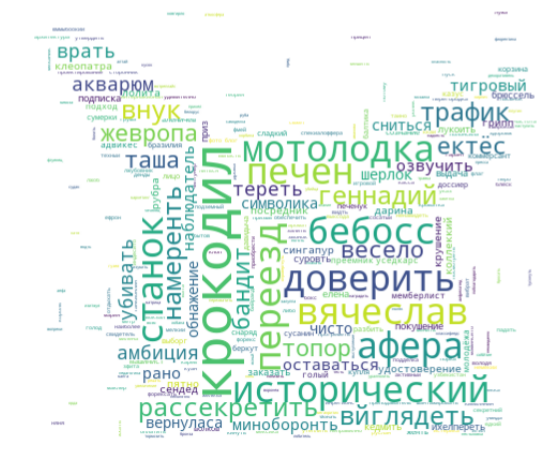

F


In [128]:
for gender in ['M', 'F']:
    print(gender)
    draw_cloud(df[df.gender==gender].translit, 3000, 2500)

<img src="https://www.meme-arsenal.com/memes/b73285d75c22a11b23444b14921df979.jpg" width=500 height=500 />

Ладно, будем жить дальше с тем, что имеем. Лемматизируем нормальные слова кириллицей, полученные ранее, и слова латиницей, которые есть в корпусах.

In [64]:
Lem = WordNetLemmatizer()

super_corp_dict = dict()
for word in tqdm(super_corp):
    lemmatized_word = Lem.lemmatize(word)
    if len(lemmatized_word)>3:
        super_corp_dict[word] = lemmatized_word

100%|██████████| 66519/66519 [00:00<00:00, 117159.93it/s]


In [62]:
rus_set = set([word for text in df.rus for word in text])

In [72]:
rus_lem_dict = dict()
for word in tqdm(rus_set):
    morphy = morph.parse(word)[0]
    if len(morphy.normal_form)>3:
        super_corp_dict[word] = morphy.normal_form

100%|██████████| 50030/50030 [00:13<00:00, 3835.49it/s]


In [73]:
super_rus_dict = translit_dict
super_rus_dict.update(rus_lem_dict)

In [ ]:
# super_rus_dict_file = "super_rus_dict.pickle"

# with open(os.environ['HOME'] + '/' + super_rus_dict_file, 'wb') as f:
#     pickle.dump(super_rus_dict, f)
    
# os.chmod(os.environ['HOME'] + '/' + super_rus_dict_file, 0o644)

# super_corp_dict_file = "super_corp_dict.pickle"

# with open(os.environ['HOME'] + '/' + super_corp_dict_file, 'wb') as f:
#     pickle.dump(super_corp_dict, f)
    
# os.chmod(os.environ['HOME'] + '/' + super_corp_dict_file, 0o644)

In [ ]:
# super_rus_dict_file = "super_rus_dict.pickle"
# super_rus_dict = pickle.load(open(super_rus_dict_file, 'rb'))
# super_corp_dict_file = "super_corp_dict.pickle"
# super_corp_dict = pickle.load(open(super_corp_dict_file, 'rb'))

Создадим общий словарь, который уже можно будет маппить к тексту ссылок. Никакой онлайн-лемматизации - нет уверенности, что она пройдет быстро на валидейшене. Будем считать что нам хватит трех сотен тысяч слов в общем словаре.

In [74]:
total_corp_dict = super_corp_dict
total_corp_dict.update(super_rus_dict)

In [75]:
len(total_corp_dict)

299665

К этому моменту я понял, что есть грандиозная проблема:

In [80]:
total_corp_dict['порно']

'порно'

In [81]:
total_corp_dict['porn']

KeyError: 'porn'

In [83]:
morph.parse('порн')[0]

Parse(word='порн', tag=OpencorporaTag('NOUN,inan,masc sing,nomn'), normal_form='порн', score=0.5, methods_stack=((<FakeDictionary>, 'порн', 33, 0), (<KnownSuffixAnalyzer>, 'орн')))

Такого слова в наших словарях, к сожалению, не оказалось - не было уверенности pymorphy в normal_form. Идем дальше - применим мегасловарь к токенам.

In [86]:
def token_all_urls(url_lst):
    text=' '.join(url_lst)

    text = re.sub('[^а-яА-Яa-zA-Z]', ' ', text)
    text = re.sub('https', ' ', text)
    text = re.sub('http', ' ', text)
    text = re.sub('www', ' ', text)    
#уже третья или четвертая проверка на http https www, кажется
    return text.lower().split()

def total_nf_from_dict(text):
    result=[]
    for word in text:
        try: result.append(total_corp_dict[word])
        except: pass
    return result

In [85]:
%%time
df['tokenized'] = df.url_set.map(token_all_urls)
df['words'] = df.tokenized.map(total_nf_from_dict)

CPU times: user 46.2 s, sys: 4.5 s, total: 50.7 s
Wall time: 50.9 s


In [88]:
df['class'] = df.gender + ' ' + df.age
df1=df[df.gender!='-']
features = 'words'
target='class'
target1='gender'
target2='age'

In [90]:
def report4(pipeline, X_train, X_test, y_train, y_test, tags, target):

    predicts_prob = pipeline.predict_proba(X_test)
    predicts = pipeline.predict(X_test)
    proba = pd.Series([max(predicts_prob[i]) for i in range(len(predicts_prob))])
    proba_diff = pd.Series([(sorted(predicts_prob[i],reverse=True)[0]-sorted(predicts_prob[i],reverse=True)[1]) 
                            for i in range(len(predicts_prob))])
    out = pd.DataFrame()
    out['y'] = y_test.reset_index()[target]
    out['pred'] = predicts
    out['prob'] = proba
    out['prob_diff'] = proba_diff
    out['correct'] = out.y==out.pred
    print('accuracy %s' % accuracy_score(predicts, y_test))
    print('prob_cut_accuracy %s' % out[out.prob>=out['prob'].median()].correct.mean())
    print('prob_diff_cut_accuracy %s' % out[out.prob_diff>=out['prob_diff'].median()].correct.mean())

In [93]:
train_target = target
X_train, X_test, y_train, y_test = train_test_split(df1[features], 
                                                    df1[train_target], 
                                                    test_size=0.20, 
                                                    random_state=42)
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(tokenizer=lambda x:x, lowercase=False, sublinear_tf=False, ngram_range=(1,1),
                              binary=True, use_idf=False, min_df=10, max_df=0.8)),
    ('clf', MultinomialNB(alpha=1))])

pipeline.fit(X_train, y_train)

tags=df1[train_target].unique()
report4(pipeline, X_train, X_test, y_train, y_test, tags, train_target)

accuracy 0.29441062534587714
prob_cut_accuracy 0.3425567238516879
prob_diff_cut_accuracy 0.35307138904261204


Не так плохо, как казалось раньше. В следующей серии попробуем собрать ансамбль из наших моделей.